#load_ue4w_demo.ipynb

This is a simple loader that downloads the 'Unlabeled E4 Wristband' dataset zipfiles, extracts the metadata, builds Pandas dataframes, and generates simple plots.

It is meant to be a minimal example with a bit of useful code that is bundled with the dataset on Zenodo.  For updated and more feature rich versions please check our [IMICS lab git repository](https://github.com/imics-lab) 

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* This version only processes accel data - the other data files should be read as well.


In [12]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
from scipy import io #for loadmat, matlab conversion
import time
import pandas as pd
import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
from time import gmtime, strftime, localtime #for displaying Linux UTC timestamps in hh:mm:ss
from datetime import datetime
from datetime import timedelta
import urllib.request # to get files from web w/o !wget

In [13]:
my_dir = "." # replace with absolute path if desired
interactive = False # change to True if you want to run each cell function
                   # if false the main function will run the entire thing
if interactive:
    zip_fname = '1568381971_A01F11.zip'
    zip_ffname = os.path.join(my_dir,zip_fname)
    zip_fullURL = 'https://zenodo.org/record/6898244/files' + zip_fname
    target_dir = my_dir + str.split(zip_ffname,'.')[1] # get rid of .zip

In [14]:
def get_ue4w_zipfile(zip_fname):
    """checks for local zipfile, if none downloads from zenodo repository
    after download will unzip the dataset into TWristAR directory.
    Assumes a global my_dir has been defined (default is my_dir = ".")
    :return: nothing"""
    zip_ffname = os.path.join(my_dir,zip_fname)
    zip_fullURL = 'https://zenodo.org/record/6898244/files/' + zip_fname
    if (os.path.exists(zip_ffname)):
        print ("Local zip file", zip_ffname, "found, skipping download")
    else:
        print ("Downloading", zip_fullURL)
        urllib.request.urlretrieve(zip_fullURL, filename=zip_fname)
    return
if interactive:
    get_ue4w_zipfile(zip_fname)

In [15]:
def unzip_e4_file(zip_ffname, target_dir):
    """checks for local copy, if none unzips the e4 zipfile in my_dir + fname
    Note:  the files themselves do not contain subject info and there are
    multiple files e.g. ACC.csv, BVP,csv etc, in each zipfile.
    It is very important to further process the files with <fname>_labels.csv
    :param zip_ffname: the path and filename of the zip file
    :param working_dir: local (colab) directory where csv files will be placed
    :return: nothing"""
    if (os.path.isdir(target_dir)):
        print("Skipping Unzip - Found existing directory", target_dir)
        return
    else:
        print("Unzipping e4 file in", target_dir)
        if (os.path.exists(zip_ffname)):
            shutil.unpack_archive(zip_ffname,target_dir,'zip')
        else:
            print("Error: ", zip_ffname, " not found, exiting")
            return
if interactive:
    unzip_e4_file(zip_ffname, target_dir)

In [16]:
def df_from_e4_csv (ffname,col_labels):
    """"reads e4 csv file, uses start time and sample rate to create time indexed
    pandas dataframe.  Note only tested with ACC files, e4 csv files do not
    have header info, this will need to be added based on file type.
    :param ffname:  full filename e.g./content/temp/ACC.csv
    :col_labels: list of colums in csv - varies by type ['accel_x','accel_y...]
    :returns df: time indexed dataframe"""

    df = pd.read_csv(ffname, header=None)
    #start_time = pd.to_datetime(df.iloc[0,0]). #pain to convert too early
    #time.time() supports number of seconds which is what this is
    start_time = df.iloc[0,0] # first line in e4 csv
    sample_freq = df.iloc[1,0] # second line in e4 csv
    df = df.drop(df.index[[0,1]]) # drop 1st two rows, index is now off by 2
    print(ffname, "Sample frequency = ", sample_freq, " Hz")
    #show time in day month format, assumes same timezone
    print("File start time = ", strftime("%a, %d %b %Y %H:%M:%S", localtime(start_time)))  
    # Make the index datetime first so code can be used for other data types
    # Having the index as datetime is required for pandas resampling
    # The start_time pulled from the e4 csv file is a float64 which represents the
    # number of seconds since January 1, 1970, 00:00:00 (UTC)
    # UTC_time is computed for each row, then made into required datetime format
    # that pandas will accept as an index
    df['UTC_time'] = (df.index-2)/sample_freq + start_time
    end_time = df['UTC_time'].iloc[-1]
    print("File end time   = ",strftime("%a, %d %b %Y %H:%M:%S", localtime(end_time)))
    print("Elapsed time HH:MM:SS", strftime("%H:%M:%S",localtime(end_time - start_time)))
    df['datetime'] = pd.to_datetime(df['UTC_time'], unit='s')
    df.set_index('datetime',inplace=True)
    df = df.drop('UTC_time', axis=1)
    df.columns = col_labels
    return df
if interactive:
    acc_ffname = target_dir + '/ACC.csv'
    col_labels = ['accel_x', 'accel_y', 'accel_z']
    my_df = df_from_e4_csv(acc_ffname, col_labels)
    print(my_df.head())

In [17]:
def process_e4_accel(df):
    """converts component accel into g and adds accel_ttl column
    per info.txt range is [-2g, 2g] and units are 1/64g.
    """
    df['accel_x'] = df['accel_x']/64
    df['accel_y'] = df['accel_y']/64
    df['accel_z'] = df['accel_z']/64
    df_sqd = df.pow(2)[['accel_x', 'accel_y', 'accel_z']] #square each accel
    df_sum = df_sqd.sum(axis=1) #add sum of squares, new 1 col df
    df.loc[:,'accel_ttl'] = df_sum.pow(0.5)-1  # sqrt and remove 1g due to gravity
    del df_sqd, df_sum
    return df
if interactive:
    my_df = process_e4_accel(my_df)
    print(my_df.head())

In [18]:
if interactive:
    my_df.iloc[1000:2000].plot(figsize=(12, 6), title = 'plotting dataframe all accel rows 1000 to 2000')

In [19]:
def show_tag_time(tag_ffname):
    """utility prints time marks from tags.csv to help with video sync 
    and labeling.   When this is run in colab it seems to be GMT regardless
    of timezone settings."
    :param tag_ffname: file to be processed e.g. /content/temp/tags.csv'
    :return: nothing"""
    try: 
        df_temp = pd.read_csv(tag_ffname, header=None)
    except:
        print("There are no tag marks in this file")
        return
    else:
        df_temp.columns = ['UTC_time']
        print ("    UTC_time          Local Time")
        for index, row in df_temp.iterrows():
            print(index, row['UTC_time'],
                strftime("%a, %d %b %Y %H:%M:%S", localtime(row['UTC_time'])))
# https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
# link to string formats for date and time
if interactive:
    tag_ffname = target_dir + '/tags.csv'
    show_tag_time(tag_ffname)

# Main Function

In [20]:
# Putting this here because it makes the main hard to read.
zip_flist = ['1568381971_A01F11.zip',
             '1568436702_A01F11.zip',
            '1568636849_A01F11.zip',
            '1568692614_A01F11.zip',
            '1568724870_A01F11.zip',
            '1568780227_A01F11.zip',
            '1568810932_A01F11.zip',
            '1568865992_000000.zip',
            '1568898255_000000.zip',
            '1568951690_000000.zip',
            '1568985613_000000.zip',
            '1569039959_000000.zip',
            '1569210942_000000.zip',
            '1569243177_000000.zip',
            '1569387025_A01F11.zip',
            '1569469882_A01F11.zip',
            '1569502137_A01F11.zip',
            '1569557287_A01F11.zip',
            '1569588599_A01F11.zip',
            '1569643907_A01F11.zip',
            '1569728107_A01F11.zip',
            '1569816129_A01F11.zip',
            '1569847922_A01F11.zip',
            '1569902565_A01F11.zip',
            '1569934211_A01F11.zip',
            '1569971145_A01F11.zip',
            '1569989395_A01F11.zip',
            '1570021036_A01F11.zip',
            '1570077840_A01F11.zip',
            '1570108887_A01F11.zip']

Iterating through 30 files in ue4w dataset
Processing  ./1568381971_A01F11.zip
Local zip file ./1568381971_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1568381971_A01F11
./1568381971_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Fri, 13 Sep 2019 13:39:31
File end time   =  Fri, 13 Sep 2019 23:35:51
Elapsed time HH:MM:SS 09:56:20
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1568382415.97 Fri, 13 Sep 2019 13:46:55
1 1568382853.79 Fri, 13 Sep 2019 13:54:13
2 1568383371.38 Fri, 13 Sep 2019 14:02:51
3 1568383693.22 Fri, 13 Sep 2019 14:08:13
4 1568386508.05 Fri, 13 Sep 2019 14:55:08
5 1568388144.71 Fri, 13 Sep 2019 15:22:24
6 1568389037.11 Fri, 13 Sep 2019 15:37:17
7 1568394897.19 Fri, 13 Sep 2019 17:14:57
8 1568395409.68 Fri, 13 Sep 2019 17:23:29
9 1568408578.39 Fri, 13 Sep 2019 21:02:58
10 1568409116.23 Fri, 13 Sep 2019 21:11:56
11 1568413887.1 Fri, 13 Sep 2019 22:31:27
12 1568414530.26 Fri, 13 Sep 2019 22:42

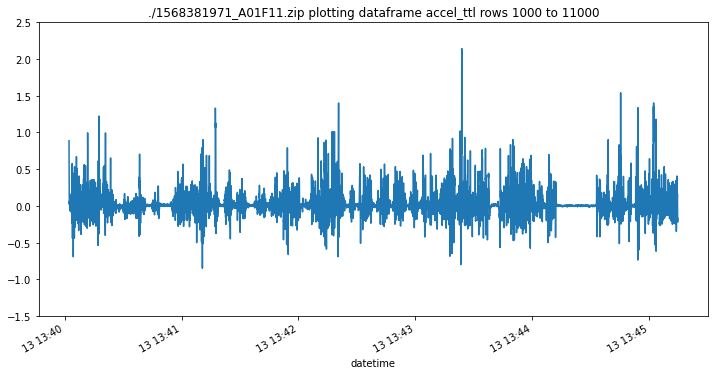

Processing  ./1568436702_A01F11.zip
Local zip file ./1568436702_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1568436702_A01F11
./1568436702_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sat, 14 Sep 2019 04:51:42
File end time   =  Sat, 14 Sep 2019 12:30:32
Elapsed time HH:MM:SS 07:38:50
Tag info (button presses) from tags.csv
There are no tag marks in this file


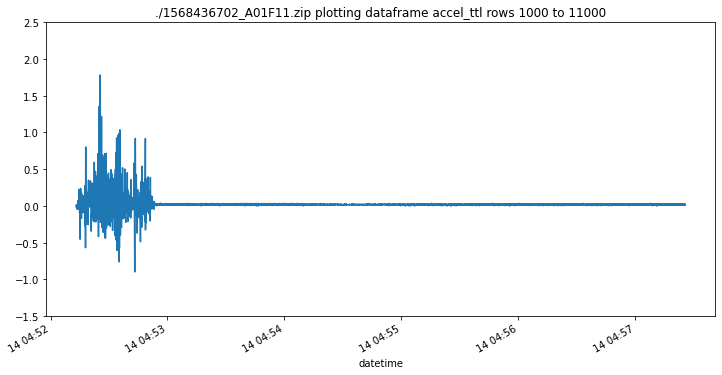

Processing  ./1568636849_A01F11.zip
Local zip file ./1568636849_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1568636849_A01F11
./1568636849_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Mon, 16 Sep 2019 12:27:29
File end time   =  Mon, 16 Sep 2019 22:48:33
Elapsed time HH:MM:SS 10:21:04
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1568638455.25 Mon, 16 Sep 2019 12:54:15
1 1568638798.87 Mon, 16 Sep 2019 12:59:58
2 1568639282.05 Mon, 16 Sep 2019 13:08:02
3 1568639699.59 Mon, 16 Sep 2019 13:14:59
4 1568641600.83 Mon, 16 Sep 2019 13:46:40
5 1568642972.47 Mon, 16 Sep 2019 14:09:32
6 1568644043.93 Mon, 16 Sep 2019 14:27:23
7 1568663932.72 Mon, 16 Sep 2019 19:58:52
8 1568670407.33 Mon, 16 Sep 2019 21:46:47
9 1568670863.47 Mon, 16 Sep 2019 21:54:23
10 1568671306.95 Mon, 16 Sep 2019 22:01:46


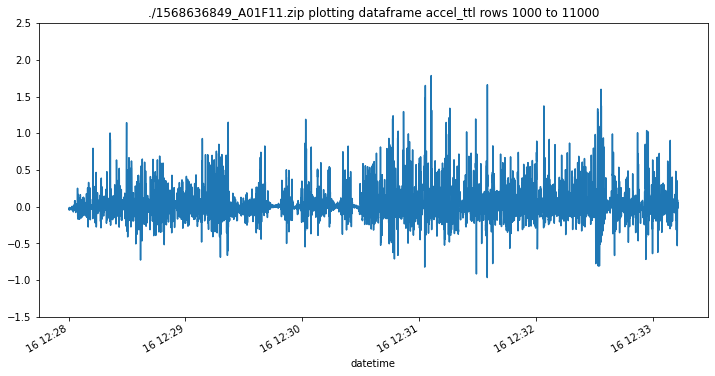

Processing  ./1568692614_A01F11.zip
Local zip file ./1568692614_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1568692614_A01F11
./1568692614_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Tue, 17 Sep 2019 03:56:54
File end time   =  Tue, 17 Sep 2019 12:09:25
Elapsed time HH:MM:SS 08:12:31
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1568721684.27 Tue, 17 Sep 2019 12:01:24


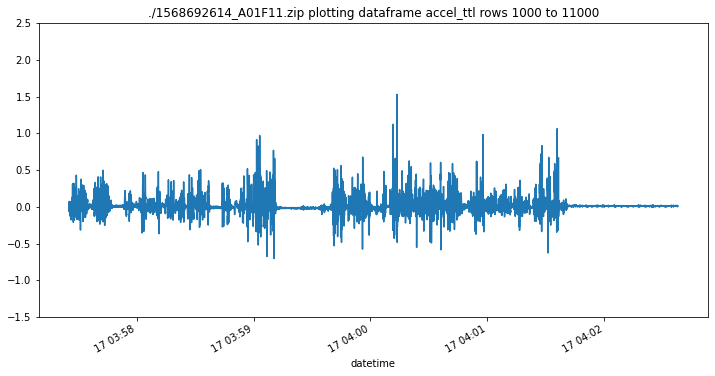

Processing  ./1568724870_A01F11.zip
Local zip file ./1568724870_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1568724870_A01F11
./1568724870_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Tue, 17 Sep 2019 12:54:30
File end time   =  Tue, 17 Sep 2019 23:56:21
Elapsed time HH:MM:SS 11:01:51
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1568725005.54 Tue, 17 Sep 2019 12:56:45
1 1568725457.39 Tue, 17 Sep 2019 13:04:17
2 1568725997.63 Tue, 17 Sep 2019 13:13:17
3 1568729953.34 Tue, 17 Sep 2019 14:19:13
4 1568732716.04 Tue, 17 Sep 2019 15:05:16
5 1568738704.58 Tue, 17 Sep 2019 16:45:04
6 1568739786.6 Tue, 17 Sep 2019 17:03:06
7 1568751122.89 Tue, 17 Sep 2019 20:12:02
8 1568758142.6 Tue, 17 Sep 2019 22:09:02
9 1568758888.67 Tue, 17 Sep 2019 22:21:28


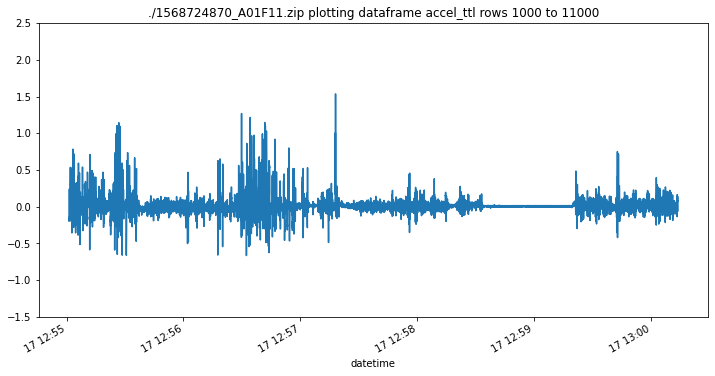

Processing  ./1568780227_A01F11.zip
Local zip file ./1568780227_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1568780227_A01F11
./1568780227_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Wed, 18 Sep 2019 04:17:07
File end time   =  Wed, 18 Sep 2019 12:19:02
Elapsed time HH:MM:SS 08:01:55
Tag info (button presses) from tags.csv
There are no tag marks in this file


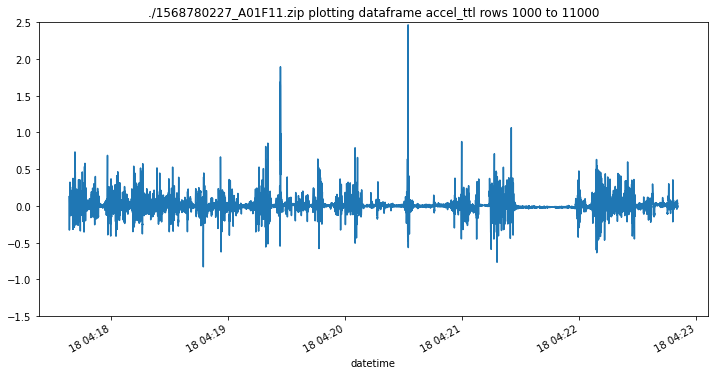

Processing  ./1568810932_A01F11.zip
Local zip file ./1568810932_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1568810932_A01F11
./1568810932_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Wed, 18 Sep 2019 12:48:52
File end time   =  Wed, 18 Sep 2019 21:19:12
Elapsed time HH:MM:SS 08:30:20
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1568810982.5 Wed, 18 Sep 2019 12:49:42
1 1568811414.9 Wed, 18 Sep 2019 12:56:54
2 1568812052.76 Wed, 18 Sep 2019 13:07:32
3 1568812441.49 Wed, 18 Sep 2019 13:14:01
4 1568814244.61 Wed, 18 Sep 2019 13:44:04
5 1568815714.6 Wed, 18 Sep 2019 14:08:34
6 1568835272.36 Wed, 18 Sep 2019 19:34:32


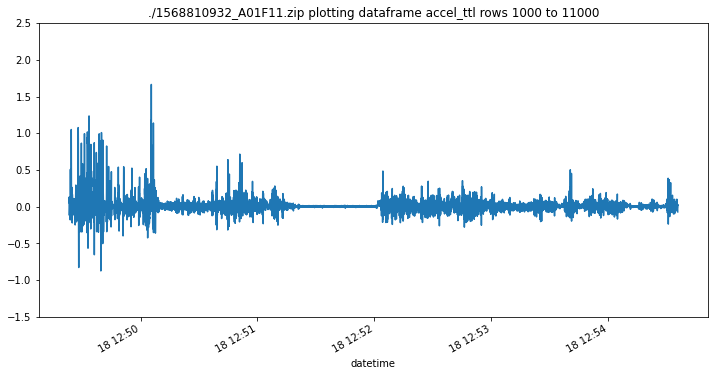

Processing  ./1568865992_000000.zip
Local zip file ./1568865992_000000.zip found, skipping download
Skipping Unzip - Found existing directory ./1568865992_000000
./1568865992_000000/ACC.csv Sample frequency =  32.0  Hz
File start time =  Thu, 19 Sep 2019 04:06:32
File end time   =  Thu, 19 Sep 2019 12:21:22
Elapsed time HH:MM:SS 08:14:50
Tag info (button presses) from tags.csv
There are no tag marks in this file


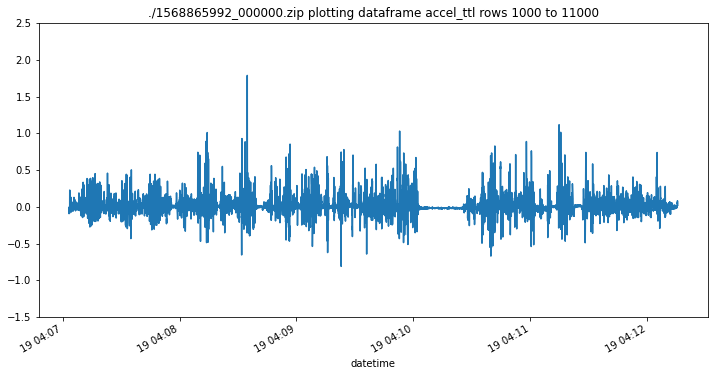

Processing  ./1568898255_000000.zip
Local zip file ./1568898255_000000.zip found, skipping download
Skipping Unzip - Found existing directory ./1568898255_000000
./1568898255_000000/ACC.csv Sample frequency =  32.0  Hz
File start time =  Thu, 19 Sep 2019 13:04:15
File end time   =  Fri, 20 Sep 2019 02:50:09
Elapsed time HH:MM:SS 13:45:54
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1568898284.64 Thu, 19 Sep 2019 13:04:44
1 1568898683.68 Thu, 19 Sep 2019 13:11:23
2 1568899366.71 Thu, 19 Sep 2019 13:22:46
3 1568901509.7 Thu, 19 Sep 2019 13:58:29
4 1568902811.01 Thu, 19 Sep 2019 14:20:11
5 1568906597.56 Thu, 19 Sep 2019 15:23:17
6 1568913650.76 Thu, 19 Sep 2019 17:20:50
7 1568914590.48 Thu, 19 Sep 2019 17:36:30
8 1568917572.61 Thu, 19 Sep 2019 18:26:12
9 1568924448.42 Thu, 19 Sep 2019 20:20:48
10 1568946379.59 Fri, 20 Sep 2019 02:26:19
11 1568946776.42 Fri, 20 Sep 2019 02:32:56
12 1568947117.48 Fri, 20 Sep 2019 02:38:37


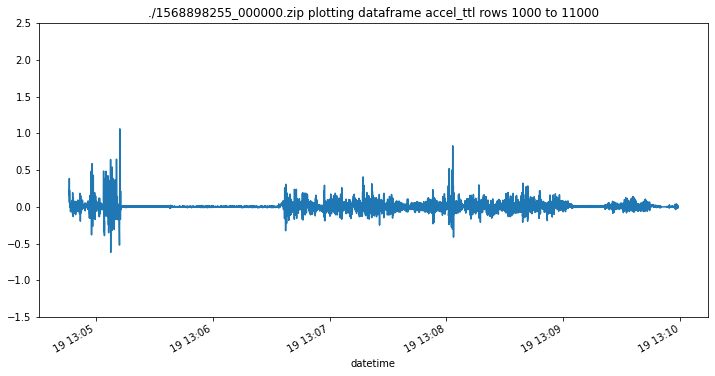

Processing  ./1568951690_000000.zip
Local zip file ./1568951690_000000.zip found, skipping download
Skipping Unzip - Found existing directory ./1568951690_000000
./1568951690_000000/ACC.csv Sample frequency =  32.0  Hz
File start time =  Fri, 20 Sep 2019 03:54:50
File end time   =  Fri, 20 Sep 2019 12:32:29
Elapsed time HH:MM:SS 08:37:39
Tag info (button presses) from tags.csv
There are no tag marks in this file


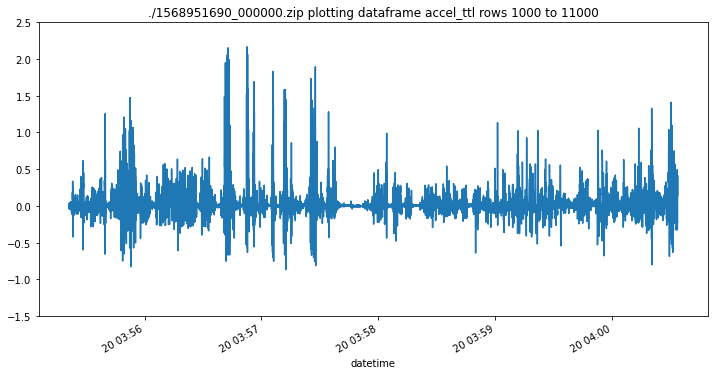

Processing  ./1568985613_000000.zip
Local zip file ./1568985613_000000.zip found, skipping download
Skipping Unzip - Found existing directory ./1568985613_000000
./1568985613_000000/ACC.csv Sample frequency =  32.0  Hz
File start time =  Fri, 20 Sep 2019 13:20:13
File end time   =  Fri, 20 Sep 2019 22:33:54
Elapsed time HH:MM:SS 09:13:41
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1568986231.39 Fri, 20 Sep 2019 13:30:31
1 1568986468.34 Fri, 20 Sep 2019 13:34:28
2 1568987067.58 Fri, 20 Sep 2019 13:44:27
3 1568987525.92 Fri, 20 Sep 2019 13:52:05
4 1568989403.21 Fri, 20 Sep 2019 14:23:23
5 1568989580.32 Fri, 20 Sep 2019 14:26:20
6 1568990841.51 Fri, 20 Sep 2019 14:47:21
7 1569001456.76 Fri, 20 Sep 2019 17:44:16
8 1569011449.7 Fri, 20 Sep 2019 20:30:49
9 1569017741.78 Fri, 20 Sep 2019 22:15:41
10 1569018096.82 Fri, 20 Sep 2019 22:21:36
11 1569018434.05 Fri, 20 Sep 2019 22:27:14


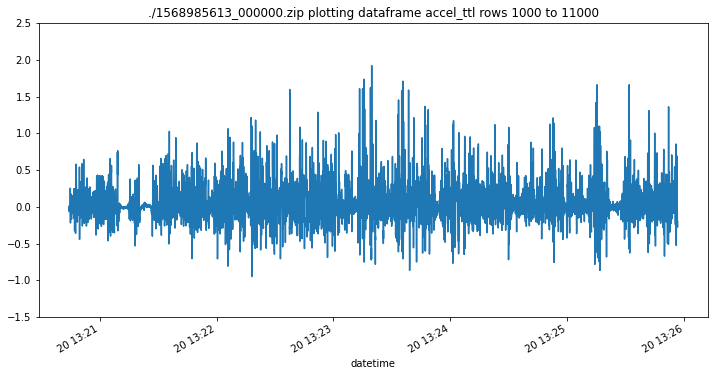

Processing  ./1569039959_000000.zip
Local zip file ./1569039959_000000.zip found, skipping download
Skipping Unzip - Found existing directory ./1569039959_000000
./1569039959_000000/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sat, 21 Sep 2019 04:25:59
File end time   =  Sat, 21 Sep 2019 13:31:46
Elapsed time HH:MM:SS 09:05:47
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1569071003.87 Sat, 21 Sep 2019 13:03:23


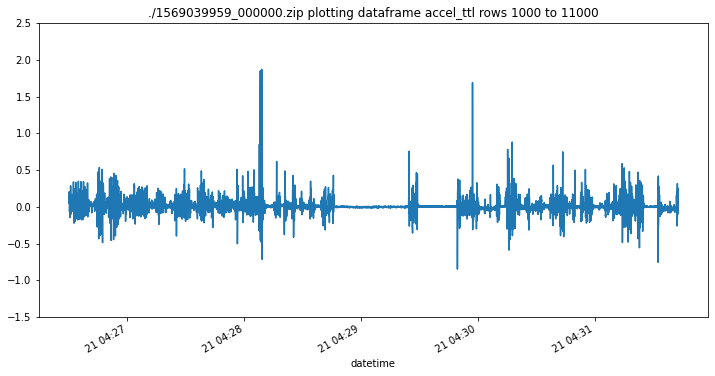

Processing  ./1569210942_000000.zip
Local zip file ./1569210942_000000.zip found, skipping download
Skipping Unzip - Found existing directory ./1569210942_000000
./1569210942_000000/ACC.csv Sample frequency =  32.0  Hz
File start time =  Mon, 23 Sep 2019 03:55:42
File end time   =  Mon, 23 Sep 2019 12:26:22
Elapsed time HH:MM:SS 08:30:40
Tag info (button presses) from tags.csv
There are no tag marks in this file


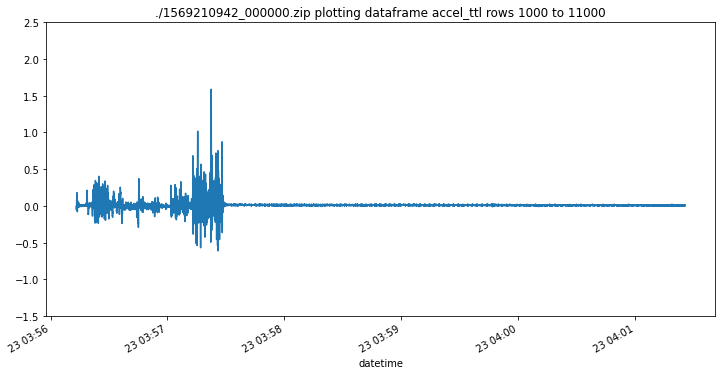

Processing  ./1569243177_000000.zip
Local zip file ./1569243177_000000.zip found, skipping download
Skipping Unzip - Found existing directory ./1569243177_000000
./1569243177_000000/ACC.csv Sample frequency =  32.0  Hz
File start time =  Mon, 23 Sep 2019 12:52:57
File end time   =  Tue, 24 Sep 2019 01:14:51
Elapsed time HH:MM:SS 12:21:54
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1569243248.77 Mon, 23 Sep 2019 12:54:08
1 1569243775.62 Mon, 23 Sep 2019 13:02:55
2 1569244261.08 Mon, 23 Sep 2019 13:11:01
3 1569244793.68 Mon, 23 Sep 2019 13:19:53
4 1569246707.96 Mon, 23 Sep 2019 13:51:47
5 1569248770.23 Mon, 23 Sep 2019 14:26:10
6 1569268404.29 Mon, 23 Sep 2019 19:53:24
7 1569268855.55 Mon, 23 Sep 2019 20:00:55
8 1569269448.28 Mon, 23 Sep 2019 20:10:48
9 1569269715.07 Mon, 23 Sep 2019 20:15:15
10 1569270675.71 Mon, 23 Sep 2019 20:31:15
11 1569275445.46 Mon, 23 Sep 2019 21:50:45
12 1569281690.89 Mon, 23 Sep 2019 23:34:50
13 1569283739.22 Tue, 24 Sep 2019 00:0

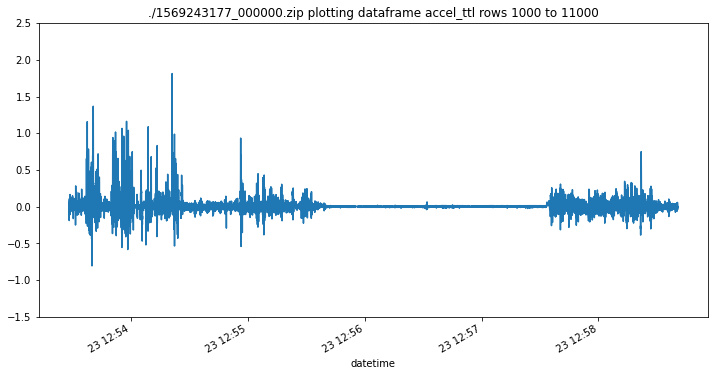

Processing  ./1569387025_A01F11.zip
Local zip file ./1569387025_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569387025_A01F11
./1569387025_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Wed, 25 Sep 2019 04:50:25
File end time   =  Wed, 25 Sep 2019 12:27:03
Elapsed time HH:MM:SS 07:36:38
Tag info (button presses) from tags.csv
There are no tag marks in this file


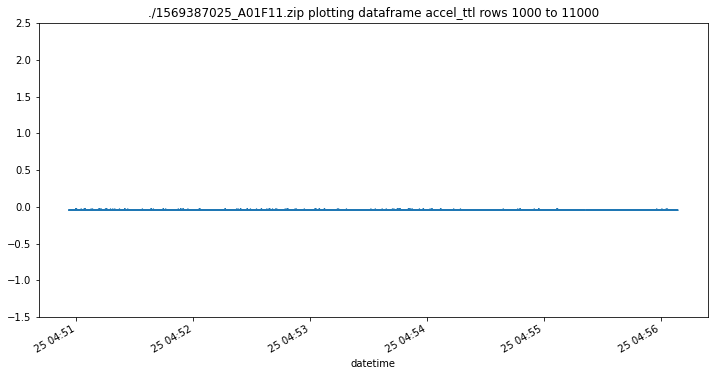

Processing  ./1569469882_A01F11.zip
Local zip file ./1569469882_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569469882_A01F11
./1569469882_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Thu, 26 Sep 2019 03:51:22
File end time   =  Thu, 26 Sep 2019 12:08:44
Elapsed time HH:MM:SS 08:17:22
Tag info (button presses) from tags.csv
There are no tag marks in this file


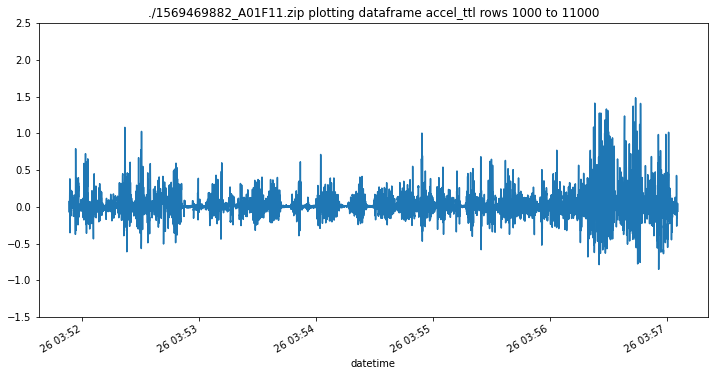

Processing  ./1569502137_A01F11.zip
Local zip file ./1569502137_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569502137_A01F11
./1569502137_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Thu, 26 Sep 2019 12:48:57
File end time   =  Fri, 27 Sep 2019 02:25:03
Elapsed time HH:MM:SS 13:36:06
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1569502276.18 Thu, 26 Sep 2019 12:51:16
1 1569502687.57 Thu, 26 Sep 2019 12:58:07
2 1569503201.06 Thu, 26 Sep 2019 13:06:41
3 1569505100.32 Thu, 26 Sep 2019 13:38:20
4 1569505923.82 Thu, 26 Sep 2019 13:52:03
5 1569507144.59 Thu, 26 Sep 2019 14:12:24
6 1569508064.82 Thu, 26 Sep 2019 14:27:44


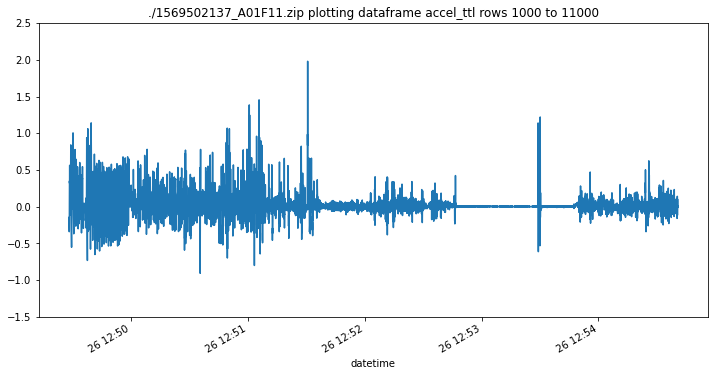

Processing  ./1569557287_A01F11.zip
Local zip file ./1569557287_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569557287_A01F11
./1569557287_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Fri, 27 Sep 2019 04:08:07
File end time   =  Fri, 27 Sep 2019 12:03:13
Elapsed time HH:MM:SS 07:55:06
Tag info (button presses) from tags.csv
There are no tag marks in this file


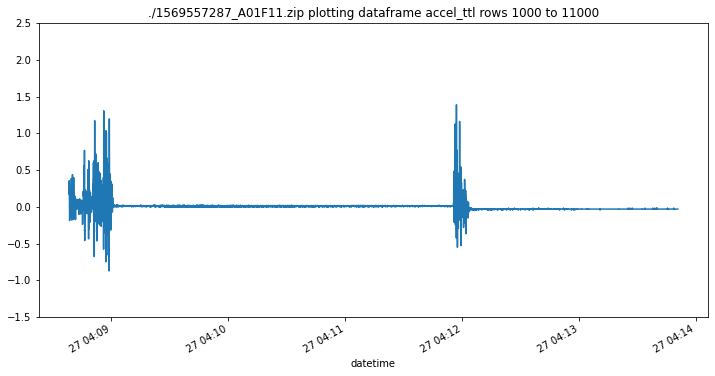

Processing  ./1569588599_A01F11.zip
Local zip file ./1569588599_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569588599_A01F11
./1569588599_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Fri, 27 Sep 2019 12:49:59
File end time   =  Fri, 27 Sep 2019 23:56:40
Elapsed time HH:MM:SS 11:06:41
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1569589322.41 Fri, 27 Sep 2019 13:02:02
1 1569589874.07 Fri, 27 Sep 2019 13:11:14
2 1569592326.17 Fri, 27 Sep 2019 13:52:06
3 1569621399.89 Fri, 27 Sep 2019 21:56:39
4 1569621840.07 Fri, 27 Sep 2019 22:04:00
5 1569622299.2 Fri, 27 Sep 2019 22:11:39


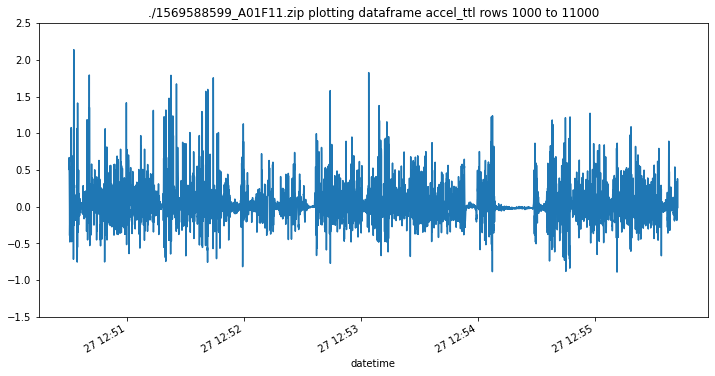

Processing  ./1569643907_A01F11.zip
Local zip file ./1569643907_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569643907_A01F11
./1569643907_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sat, 28 Sep 2019 04:11:47
File end time   =  Sat, 28 Sep 2019 12:31:18
Elapsed time HH:MM:SS 08:19:31
Tag info (button presses) from tags.csv
There are no tag marks in this file


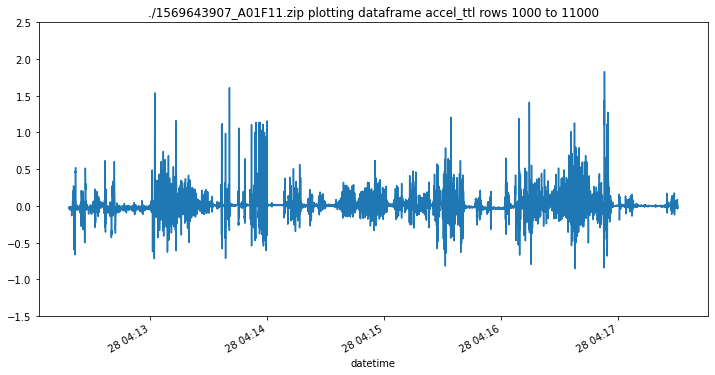

Processing  ./1569728107_A01F11.zip
Local zip file ./1569728107_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569728107_A01F11
./1569728107_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sun, 29 Sep 2019 03:35:07
File end time   =  Sun, 29 Sep 2019 12:52:27
Elapsed time HH:MM:SS 09:17:20
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1569729135.74 Sun, 29 Sep 2019 03:52:15
1 1569761221.38 Sun, 29 Sep 2019 12:47:01


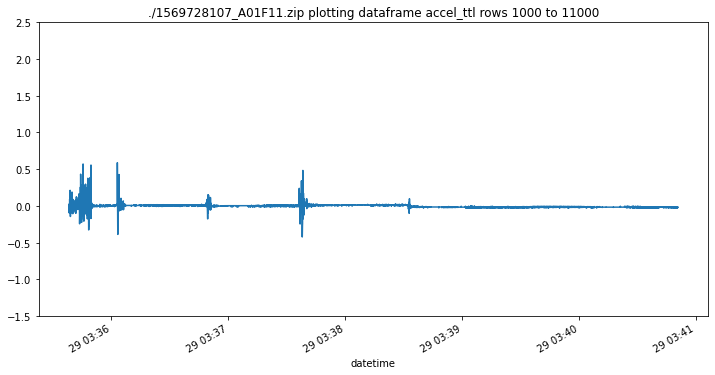

Processing  ./1569816129_A01F11.zip
Local zip file ./1569816129_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569816129_A01F11
./1569816129_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Mon, 30 Sep 2019 04:02:09
File end time   =  Mon, 30 Sep 2019 08:20:09
Elapsed time HH:MM:SS 04:18:00
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1569816718.64 Mon, 30 Sep 2019 04:11:58


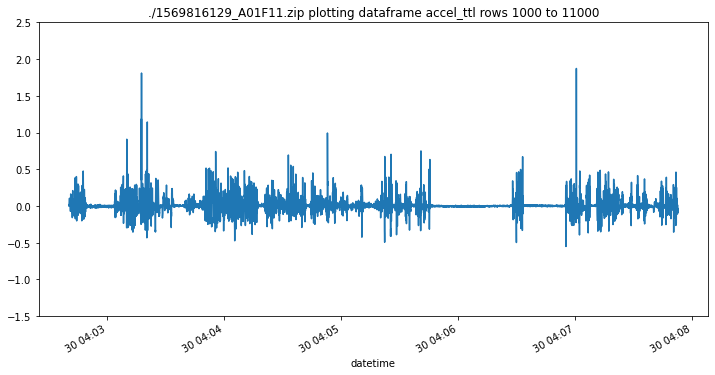

Processing  ./1569847922_A01F11.zip
Local zip file ./1569847922_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569847922_A01F11
./1569847922_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Mon, 30 Sep 2019 12:52:02
File end time   =  Mon, 30 Sep 2019 22:01:57
Elapsed time HH:MM:SS 09:09:55
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1569848045.8 Mon, 30 Sep 2019 12:54:05
1 1569848499.1 Mon, 30 Sep 2019 13:01:39
2 1569849330.88 Mon, 30 Sep 2019 13:15:30
3 1569851173.49 Mon, 30 Sep 2019 13:46:13
4 1569852444.52 Mon, 30 Sep 2019 14:07:24
5 1569872901.91 Mon, 30 Sep 2019 19:48:21
6 1569880359.06 Mon, 30 Sep 2019 21:52:39
7 1569880839.88 Mon, 30 Sep 2019 22:00:39


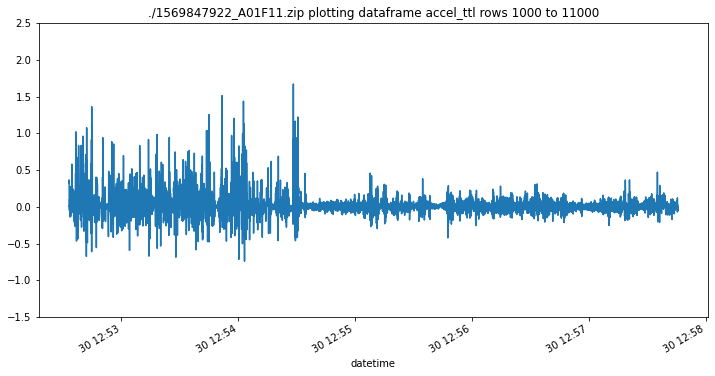

Processing  ./1569902565_A01F11.zip
Local zip file ./1569902565_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569902565_A01F11
./1569902565_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Tue, 01 Oct 2019 04:02:45
File end time   =  Tue, 01 Oct 2019 12:10:32
Elapsed time HH:MM:SS 08:07:47
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1569903424.65 Tue, 01 Oct 2019 04:17:04
1 1569931577.03 Tue, 01 Oct 2019 12:06:17


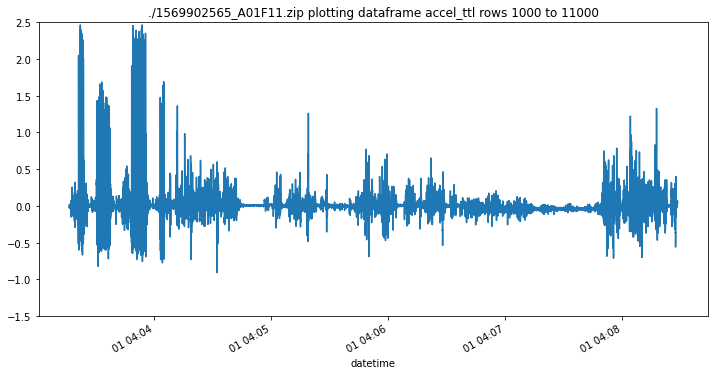

Processing  ./1569934211_A01F11.zip
Local zip file ./1569934211_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569934211_A01F11
./1569934211_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Tue, 01 Oct 2019 12:50:11
File end time   =  Tue, 01 Oct 2019 23:02:38
Elapsed time HH:MM:SS 10:12:27
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1569934280.96 Tue, 01 Oct 2019 12:51:20
1 1569934768.85 Tue, 01 Oct 2019 12:59:28
2 1569935375.29 Tue, 01 Oct 2019 13:09:35
3 1569937046.55 Tue, 01 Oct 2019 13:37:26
4 1569937772.65 Tue, 01 Oct 2019 13:49:32
5 1569938995.32 Tue, 01 Oct 2019 14:09:55
6 1569940119.63 Tue, 01 Oct 2019 14:28:39
7 1569942094.08 Tue, 01 Oct 2019 15:01:34
8 1569961015.32 Tue, 01 Oct 2019 20:16:55
9 1569967679.88 Tue, 01 Oct 2019 22:07:59
10 1569968363.63 Tue, 01 Oct 2019 22:19:23


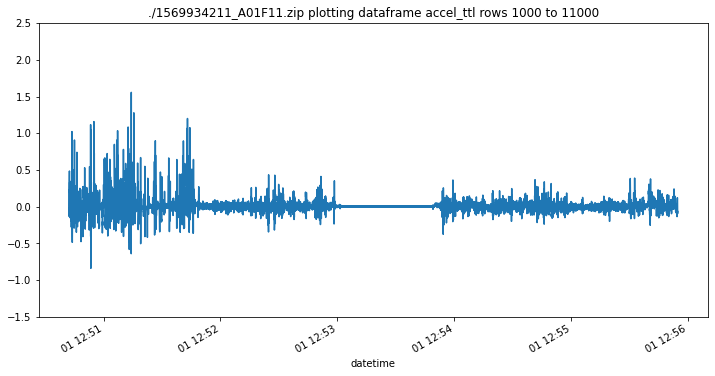

Processing  ./1569971145_A01F11.zip
Local zip file ./1569971145_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569971145_A01F11
./1569971145_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Tue, 01 Oct 2019 23:05:45
File end time   =  Wed, 02 Oct 2019 04:08:45
Elapsed time HH:MM:SS 05:03:00
Tag info (button presses) from tags.csv
There are no tag marks in this file


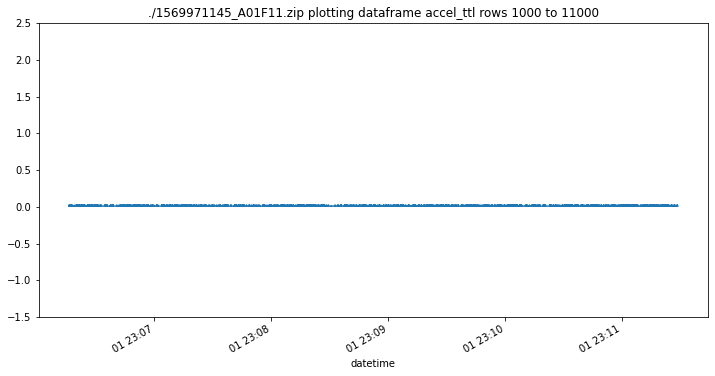

Processing  ./1569989395_A01F11.zip
Local zip file ./1569989395_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1569989395_A01F11
./1569989395_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Wed, 02 Oct 2019 04:09:55
File end time   =  Wed, 02 Oct 2019 12:11:08
Elapsed time HH:MM:SS 08:01:13
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1569990449.72 Wed, 02 Oct 2019 04:27:29
1 1570018184.6 Wed, 02 Oct 2019 12:09:44


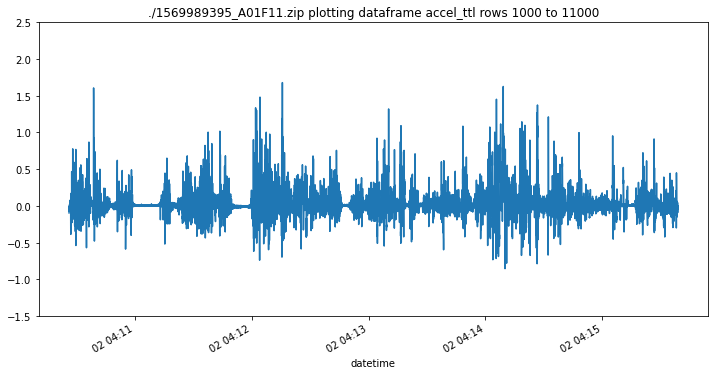

Processing  ./1570021036_A01F11.zip
Local zip file ./1570021036_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1570021036_A01F11
./1570021036_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Wed, 02 Oct 2019 12:57:16
File end time   =  Thu, 03 Oct 2019 00:11:54
Elapsed time HH:MM:SS 11:14:38
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1570021410.58 Wed, 02 Oct 2019 13:03:30
1 1570021960.03 Wed, 02 Oct 2019 13:12:40
2 1570022251.46 Wed, 02 Oct 2019 13:17:31
3 1570025212.07 Wed, 02 Oct 2019 14:06:52
4 1570047550.07 Wed, 02 Oct 2019 20:19:10
5 1570048750.77 Wed, 02 Oct 2019 20:39:10


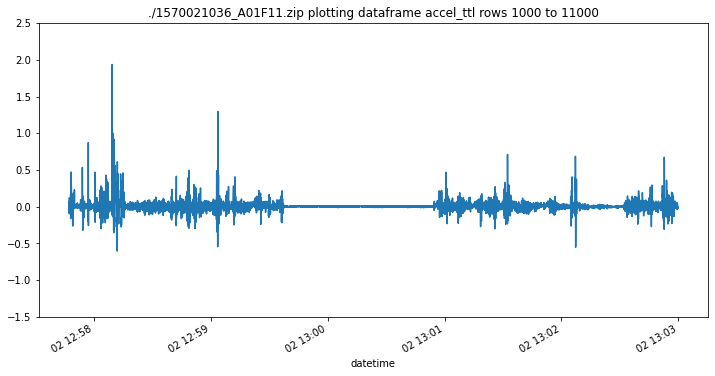

Processing  ./1570077840_A01F11.zip
Local zip file ./1570077840_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1570077840_A01F11
./1570077840_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Thu, 03 Oct 2019 04:44:00
File end time   =  Thu, 03 Oct 2019 12:33:23
Elapsed time HH:MM:SS 07:49:23
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1570105123.58 Thu, 03 Oct 2019 12:18:43


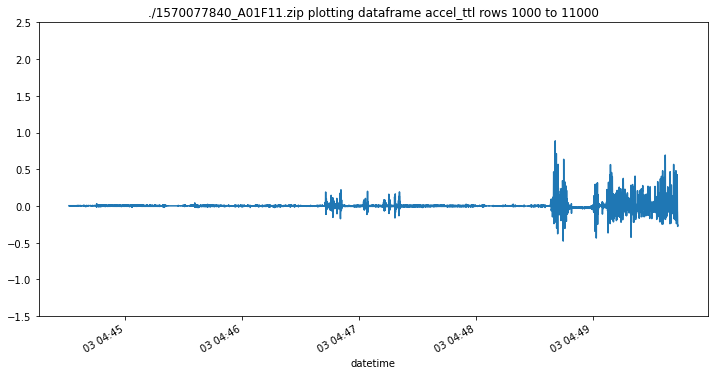

Processing  ./1570108887_A01F11.zip
Local zip file ./1570108887_A01F11.zip found, skipping download
Skipping Unzip - Found existing directory ./1570108887_A01F11
./1570108887_A01F11/ACC.csv Sample frequency =  32.0  Hz
File start time =  Thu, 03 Oct 2019 13:21:27
File end time   =  Fri, 04 Oct 2019 02:21:42
Elapsed time HH:MM:SS 13:00:15
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1570108972.22 Thu, 03 Oct 2019 13:22:52
1 1570122995.81 Thu, 03 Oct 2019 17:16:35
2 1570139771.88 Thu, 03 Oct 2019 21:56:11
3 1570140359.85 Thu, 03 Oct 2019 22:05:59
4 1570154779.05 Fri, 04 Oct 2019 02:06:19
5 1570155215.64 Fri, 04 Oct 2019 02:13:35
6 1570155700.17 Fri, 04 Oct 2019 02:21:40


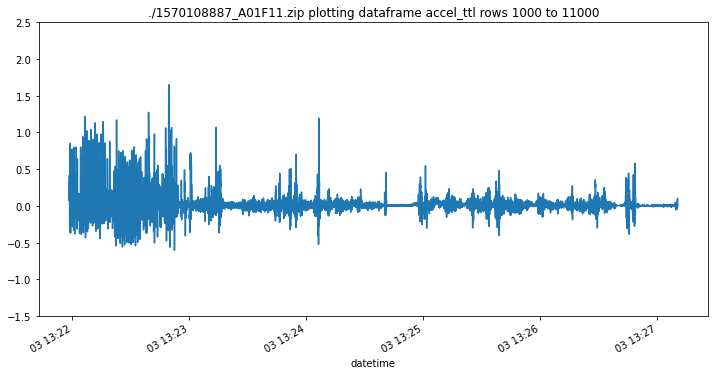

In [21]:
if __name__ == "__main__":
    if interactive:
        print("Warning:  Interactive mode enabled, results & plots may be off.")
    print("Iterating through", len(zip_flist), "files in ue4w dataset")
    # zip_flist = [''1568381971_A01F11.zip', '1568436702_A01F11.zip']
    for zip_fname in zip_flist:
        zip_ffname = os.path.join(my_dir,zip_fname)
        target_dir = my_dir + str.split(zip_ffname,'.')[1] # get rid of .zip
        print('Processing ', zip_ffname)
        get_ue4w_zipfile(zip_fname)
        unzip_e4_file(zip_ffname,target_dir)
        # following portion of code is unique to ACC only files
        ffname = target_dir + '/ACC.csv'
        col_labels = ['accel_x', 'accel_y', 'accel_z']
        my_df = df_from_e4_csv(ffname, col_labels)
        my_df = process_e4_accel(my_df)
        #print(my_df.head())
        print('Tag info (button presses) from tags.csv')
        tag_ffname = target_dir + '/tags.csv'
        show_tag_time(tag_ffname)
        my_df['accel_ttl'].iloc[1000:11000].plot(figsize=(12, 6), ylim=(-1.5,2.5), title = zip_ffname + ' plotting dataframe accel_ttl rows 1000 to 11000')
        plt.show()